<IPython.core.display.Javascript object>


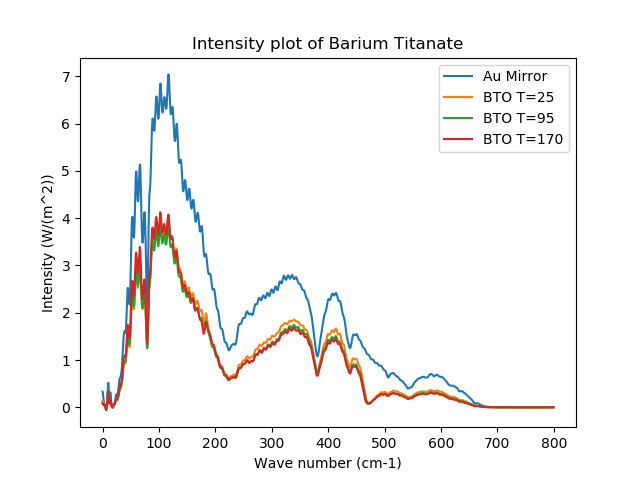

In [8]:
#These are all the modules required for the program

import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

%matplotlib notebook
#Import all important data for the initial test plots, The data provided are Listed in two columns 'Wave number' and 'Intensity'
#Mirror data is the spectra of gold which is assumed to be 100% reflective.
Mirror_data = pd.read_csv(r"C:\Users\user\Desktop\Project physics 4th year\BTO_temperature\110C_Au_test.txt",header=None,names = ["W_num","Int_mirror"])

#3 data for BTO at different temp points (simply add more to jump into pca but 3 is enough for visualisation)
T25BTO = pd.read_csv(r"C:\Users\user\Desktop\Project physics 4th year\BTO_temperature\BTO_100B_T_25p6.txt",header = None,names= ["T25_w_num","Int_T25"])
T95BTO = pd.read_csv(r"C:\Users\user\Desktop\Project physics 4th year\BTO_temperature\BTO_100B_T_95.0",header=None,names = ['T95_w_num','Int_T95'])
T170BTO = pd.read_csv(r"C:\Users\user\Desktop\Project physics 4th year\BTO_temperature\BTO_100B_T_170t.txt",header=None,names = ['T170_w_num','Int_T170'])

#opening up a figure to view the data

plt.figure()
plt.plot(Mirror_data["W_num"],Mirror_data["Int_mirror"],label='Au Mirror')
plt.plot(T25BTO["T25_w_num"],T25BTO["Int_T25"],label='BTO T=25')
plt.plot(T95BTO["T95_w_num"],T95BTO["Int_T95"],label='BTO T=95')
plt.plot(T170BTO["T170_w_num"],T170BTO["Int_T170"],label='BTO T=170')
plt.legend(loc='upper right')
plt.xlabel('Wave number (cm-1)')
plt.ylabel('Intensity (W/(m^2))')
plt.title('Intensity plot of Barium Titanate')
plt.rc('axes',titlesize = 10)
plt.rc('axes',labelsize = 10)
# plt.savefig('initial with Au')

In [9]:

#We can calculate the reflectance now by comparing all the sample Intensity against the mirror's Intensity.  
Reflectance = {'w_num':(Mirror_data['W_num']),'T25':(T25BTO['Int_T25']/Mirror_data['Int_mirror'])
              ,'T95':(T95BTO['Int_T95']/Mirror_data['Int_mirror']),'T170':(T170BTO['Int_T170']/Mirror_data['Int_mirror'])}
BTO_r = pd.DataFrame(Reflectance)

#Ommiting all values outside of range of the equipment used for measurement and keeping only relevant data points leavs us with about 600 data points
BTO_r = BTO_r.loc[(BTO_r['w_num']>50) & (BTO_r['w_num']<650)]

#Plot to view if the reflecance data looks okay otherwise we can go onto performing PCA.

In [10]:
#Need to isolate the Reflectance values since we want dont want to perform PCA on the frequencies.
#in order to do so we create these columns
Temps = ['T25','T95','T170']
W_num = ['w_num']

#Now we can use the above columns to extract just those values from the dataframe.
x = BTO_r.loc[:,Temps].values.astype('float32')
y = BTO_r.loc[:,W_num].values

In [11]:
# fit transform shifts the values of our data to have a mean value of 0,0.Included in the python principal component library
pc = StandardScaler().fit_transform(x)

#number of components for the principal components. 3 was choosen since we are only working with 3 columns of data and it cannot exceed that for our code.
pca = PCA(n_components=3)

#final fit formula to fit our transformed data into the number of components necessary
principal_comp = pca.fit_transform(pc)

In [12]:
#To explore how much variance is in our data we need to use pca's inbuilt function that explains the variance ratio of each component
varianc = pca.explained_variance_ratio_
tvarianc = np.cumsum(varianc)
variance = pd.DataFrame(varianc)
tvariance = pd.DataFrame(tvarianc)

#This will give a solid idea as to how many PCA you need to consider, We want the cumalitive values (tvariance) to be close to 100%
#If however, the data is extremely spread out we can set cutoffs at 80%, 90% depending on the data.

In [13]:
# move the index of the dataframe by 1 so that the plot looks cleaner and fits pca1 to 1 instead of pca1 to 0.
variance.index = variance.index + 1
tvariance.index = tvariance.index +1

In [14]:
#Extracting the actual components
pdf = pd.DataFrame(principal_comp,columns = ['PC1','PC2','PC3'])

#Extracting the loadings, these will tell you how the components are related to your original data
#Loadings are stored in a different shape then your data so in order to properly plot and visualise we can get the transpose.
loadings = pca.components_.T
loadings_matrix = pca.components_.T * np.sqrt(pca.explained_variance_)

#We can now create the dataframe that will store these loadings, We can also create a Temperature array for plots.
loadings_df = pd.DataFrame(loadings,columns = ['PC1','PC2','PC3'])
Temp_p = np.array([25,95,170])

#In order to understand the data we can create plots of different things extracted above.

In [15]:
# 1 - plot of pdf columns vs wavenumbers will give you a general view of what kind of info the components contain.
# 2 - plot of loadings vs temperature array will give you a good idea of the data as a function of temperature.


# 3 - plot of loadings for PC1 vs loadings of PC2 (and so on) will give you a good idea of what temperatures are similar 
#   - if in this plot lets say T = 25 at 30 volts and T = 175 at 0 volts are in the same position you can say that these 
#   - temperatures at these voltage have the same behaviour and so on.

In [16]:
# Go through a quick data filtering method.
import scipy as sp
from scipy import fft
from scipy import ifft
from numpy.fft import fft,ifft,fftfreq


In [18]:
#fft for one of the temperature data ( T=25).
#fast fourier transform initial data
xf = np.fft.fft(BTO_r['T25'])


#create a frequency out of our original data using the difference between each data point.
fftfreq = np.fft.fftfreq(len(BTO_r['w_num']), np.diff(BTO_r['w_num'])[0])


#inbuilt fft shifts data so we need to shift our frequency due to the negative postive sorting of fft
freqshift = np.fft.fftshift(fftfreq)


#shift the corresponding frequency value then get the power spectrum of our data.
power_ = np.fft.fftshift(np.abs(xf))
power = power_**2


#try only plotting positive as mirrored
m_freq = np.where(freqshift > 0)
p_freq = freqshift[m_freq]

#here we can now plot the values for power where m_freq is true as power[m_freq] against p_freq and see where our noise lies.
#  The idea is to filter out the periodic noise which is seen right at the start of the plot, since we are plotting half of the
#  transformed data, we get this mirrored on the end of the data showing us it's periodic noise.
#  We can choose an arbitary low pass filter to filter anything above this value as 0.
low_pass_filter = 0.05
xf[np.abs(fftfreq)> low_pass_filter] = 0

#Inverse transform the filtered data
filterfft = np.fft.ifft(xf)
fil = np.abs(filterfft)

<IPython.core.display.Javascript object>


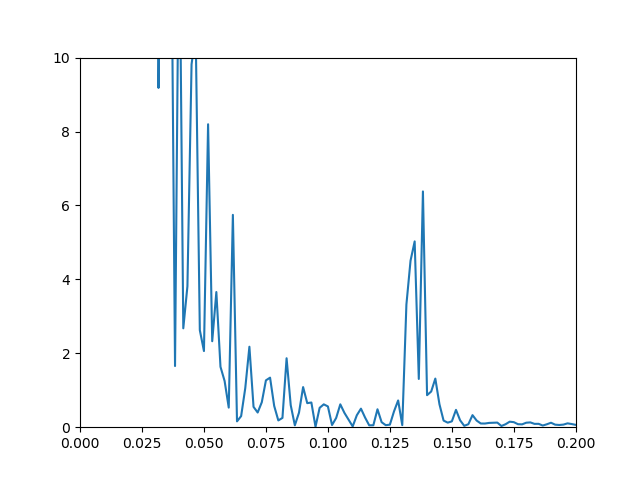

(0, 10)

In [24]:
#To view the power spectrum in order to decide upon a cutoff frequency use the following plot commands.
plt.figure()
plt.plot(p_freq,power[m_freq])
plt.xlim(0,0.2)
plt.ylim(0,10)
#adjust the limits in x and y if the transformed data is out of range.